<a href="https://colab.research.google.com/github/EmNeuro/Music-Analysis/blob/main/Voice_detection_in_music_classifiers_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code takes labled mp3s and performs analysis to create a modle and determine if mp3 music has a voice or no voice

Music was taken from Jamendo Music, for music with voices songs from PLAYLIST Indie were selceted. For non - voiced musice songs from PLAYLIST INS

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Imports

In [2]:
!pip install pydub python_speech_features
!pip install scikit-learn
!pip install seaborn



In [3]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from scipy.io import wavfile
from python_speech_features import mfcc
from pydub import AudioSegment
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


## Check data files and labeling

In [4]:
## check song lables

def print_filenames(directory):
    labels = {'voice': 0, 'no_voice': 0}

    for filename in os.listdir(directory):
        if filename.endswith(".mp3"):
            label = 'no_voice' if 'no_voice' in filename.lower() else 'voice'
            labels[label] += 1
            print(f"Filename: {filename}, Label: {label}")

    print("Number of voice samples available:", labels['voice'])
    print("Number of no_voice samples available:", labels['no_voice'])

# Print filenames and labels
dataset_directory = '/content/drive/MyDrive/EmilysPersonalFolder/music'
print_filenames(dataset_directory)


Filename: 035-11903-Arietys-Aria - Suite n&deg;3 pour orchestre en re majeur de J-S Bach _Arietys Remix__no_voice.mp3, Label: no_voice
Filename: 030-1543086-King Gizzard _amp_ The Lizard Wizard-King Gizzard _amp_ the Lizard Wizard - Deserted Dunes Welcome Weary Feet_voice.mp3, Label: voice
Filename: 016-1418241-SadMe-Done With You_voice.mp3, Label: voice
Filename: 028-182875-Daniel Bautista-Symphony No. 5_no_voice.mp3, Label: no_voice
Filename: 043-47371-The Verandas-give me a sign_voice.mp3, Label: voice
Filename: 024-604690-Icarus Crash-Yaviyahu_voice.mp3, Label: voice
Filename: 044-1605782-Plants-Misery Business_voice.mp3, Label: voice
Filename: 047-1607713-Talking Cure-The Old Actor_voice.mp3, Label: voice
Filename: 032-1636939-Aquarius Blue-Caribbean Sun_voice.mp3, Label: voice
Filename: 036-1733592-Emerald Park-BIGFOOT _CC-version__voice.mp3, Label: voice
Filename: 048-1722662-Mouse In Da Chaos-Set The Goals_voice.mp3, Label: voice
Filename: 037-1741601-Paper Clips-Too Wide_voice

Functions to load MP3, then convert to wav, transform and extract features based on mfcc then runs a Random Forest classifier from scikit-learn.

In [4]:
from pydub import AudioSegment
from scipy.io import wavfile
from python_speech_features import mfcc
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define a function to extract features from an MP3 file
def extract_features(file_path, max_sequence_length=None):
    # Load the MP3 file using pydub
    audio = AudioSegment.from_mp3(file_path)

    # Convert to mono (if stereo)
    if audio.channels > 1:
        audio = audio.set_channels(1)

    # Export the audio as a temporary WAV file
    temp_wav_path = "/tmp/temp.wav"
    audio.export(temp_wav_path, format="wav")

    # Read the temporary WAV file
    rate, signal = wavfile.read(temp_wav_path)

    # Increase NFFT to avoid the warning
    nfft_value = 2048  # You can adjust this value based on the warning message
    # Extract MFCC features using python_speech_features
    mfcc_features = mfcc(signal, rate, nfft=nfft_value)

    # Calculate the mean sequence length
    mean_sequence_length = int(np.mean([len(seq) for seq in mfcc_features]))

    # Set max_sequence_length to the mean if not specified
    if max_sequence_length is None:
        max_sequence_length = mean_sequence_length

    # Pad the sequences to the mean sequence length
    mfcc_features = pad_sequences([mfcc_features], maxlen=max_sequence_length, padding='post', truncating='post')[0]

    # Flatten the 2D array into a 1D array
    flat_features = np.ravel(mfcc_features)

    return flat_features

# Function to load data with MFCC features
def load_data(directory, max_songs_per_category=48):
    features = []
    labels = {'voice': 0, 'no_voice': 0}

    for filename in os.listdir(directory):
        if filename.endswith(".mp3"):
            # Modify the labeling logic based on the filename
            if 'no_voice' in filename.lower():
                labels['no_voice'] += 1
            elif 'voice' in filename.lower():
                labels['voice'] += 1

    print("Number of voice samples available:", labels['voice'])
    print("Number of no_voice samples available:", labels['no_voice'])

    # Check if the number of samples for both categories is sufficient
    if labels['voice'] >= max_songs_per_category and labels['no_voice'] >= max_songs_per_category:
        print("Sufficient samples available for both categories.")
        # Proceed with loading data
        voice_samples, no_voice_samples = 0, 0
        for filename in os.listdir(directory):
            if filename.endswith(".mp3"):
                file_path = os.path.join(directory, filename)

                # Modify the labeling logic based on the filename
                if 'no_voice' in filename.lower() and no_voice_samples < max_songs_per_category:
                    no_voice_samples += 1
                    features.append(extract_features(file_path))
                elif 'voice' in filename.lower() and voice_samples < max_songs_per_category:
                    voice_samples += 1
                    features.append(extract_features(file_path))

                # Check if the required number of songs for both categories is reached
                if voice_samples == max_songs_per_category and no_voice_samples == max_songs_per_category:
                    break

        # Load data into NumPy arrays
        X = np.array(features)
        y = np.array([1] * voice_samples + [0] * no_voice_samples)
        return X, y
    else:
        raise ValueError("Insufficient samples available for one or both categories.")

# Load limited data from your dataset directory
dataset_directory = '/content/drive/MyDrive/EmilysPersonalFolder/music'
X, y = load_data(dataset_directory, max_songs_per_category=45)

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Build a pipeline with preprocessing, dimensionality reduction, and a classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10)),  # Choose a specific number of components (e.g., 10)
    ('classifier', RandomForestClassifier())
])

# Define hyperparameters for GridSearchCV
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Predict on the validation set
y_val_pred = grid_search.predict(X_val)
accuracy_val = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", accuracy_val)

# Predict on the test set
y_test_pred = grid_search.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", accuracy_test)


Number of voice samples available: 53
Number of no_voice samples available: 48
Sufficient samples available for both categories.
Best hyperparameters: {'classifier__max_depth': 20, 'classifier__n_estimators': 100}
Validation Accuracy: 0.45454545454545453
Test Accuracy: 0.6086956521739131


Just functions to load and save and extract


In [5]:
import os
import numpy as np
from pydub import AudioSegment
from scipy.io import wavfile
from python_speech_features import mfcc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Function to extract features from an MP3 file
def extract_features(file_path, max_sequence_length=None):
    # Load the MP3 file using pydub
    audio = AudioSegment.from_mp3(file_path)

    # Convert to mono (if stereo)
    if audio.channels > 1:
        audio = audio.set_channels(1)

    # Export the audio as a temporary WAV file
    temp_wav_path = "/tmp/temp.wav"
    audio.export(temp_wav_path, format="wav")

    # Read the temporary WAV file
    rate, signal = wavfile.read(temp_wav_path)

    # Increase NFFT to avoid the warning
    nfft_value = 2048  # You can adjust this value based on the warning message
    # Extract MFCC features using python_speech_features
    mfcc_features = mfcc(signal, rate, nfft=nfft_value)

    # Calculate the mean sequence length
    mean_sequence_length = int(np.mean([len(seq) for seq in mfcc_features]))

    # Set max_sequence_length to the mean if not specified
    if max_sequence_length is None:
        max_sequence_length = mean_sequence_length

    # Pad the sequences to the mean sequence length
    mfcc_features = pad_sequences([mfcc_features], maxlen=max_sequence_length, padding='post', truncating='post')[0]

    # Flatten the 2D array into a 1D array
    flat_features = np.ravel(mfcc_features)

    return flat_features

# Function to load or save preprocessed data
def load_or_save_preprocessed_data(directory, max_songs_per_category=10, save_path=None, load_path=None):
    if load_path is not None:
        # Load data from the specified path
        loaded_data = np.load(load_path)
        if 'features' in loaded_data:
            X, y, features = loaded_data['X'], loaded_data['y'], loaded_data['features']
            print("Data loaded from:", load_path)
        else:
            # Handle loading old data without the 'features' key
            print("Old data loaded from:", load_path)
            print("Reprocessing data...")
            X, y, features = process_and_save_data(directory, max_songs_per_category, save_path)
    else:
        # Load or save the data
        print("Processing data...")
        X, y, features = process_and_save_data(directory, max_songs_per_category, save_path)

    return X, y, features

def process_and_save_data(directory, max_songs_per_category, save_path):
    features = []
    labels = {'voice': 0, 'no_voice': 0}

    for filename in os.listdir(directory):
        if filename.endswith(".mp3"):
            file_path = os.path.join(directory, filename)

            # Modify the labeling logic based on the filename
            if 'no_voice' in filename.lower() and labels['no_voice'] < max_songs_per_category:
                labels['no_voice'] += 1
                features.append(extract_features(file_path))
            elif 'voice' in filename.lower() and labels['voice'] < max_songs_per_category:
                labels['voice'] += 1
                features.append(extract_features(file_path))

    # Load data into NumPy arrays
    X = np.array(features)
    y = np.array([0] * labels['no_voice'] + [1] * labels['voice'])

    if save_path is not None:
        # Save the data and features to the specified path
        np.savez(save_path, X=X, y=y, features=features)
        print("Data saved to:", save_path)

    return X, y, features




Compare mulitple classifiers

Data loaded from: /content/drive/MyDrive/EmilysPersonalFolder/music/preprocessed_data.npz
Random Forest Average Accuracy: 0.6444444444444445
Random Forest Test Accuracy: 0.5111111111111111


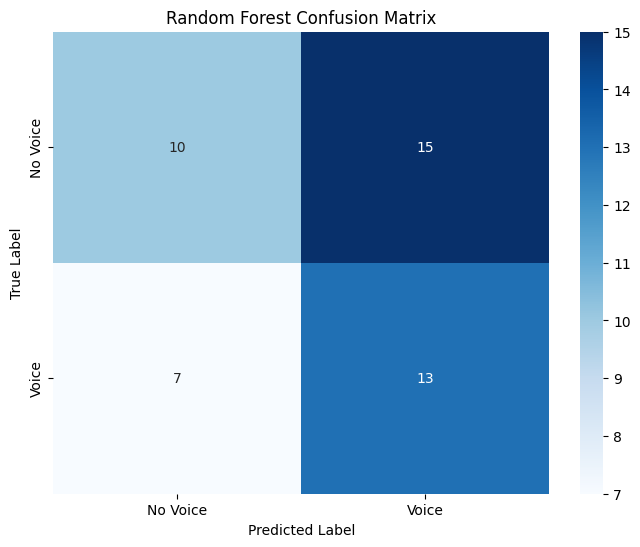

SVM Average Accuracy: 0.7333333333333334
SVM Test Accuracy: 0.5111111111111111


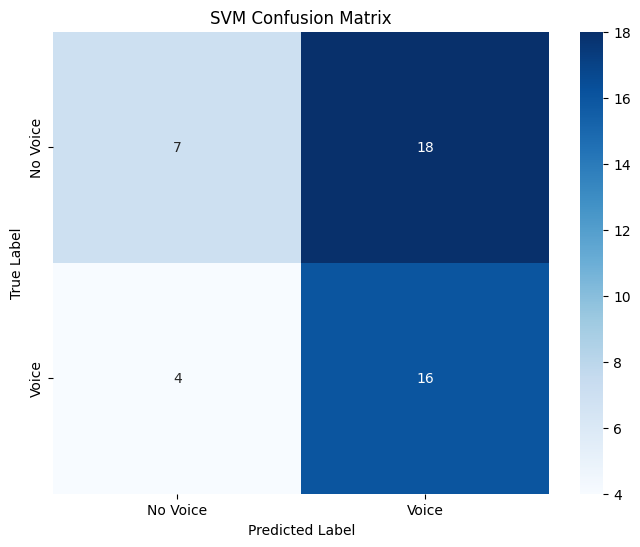

Logistic Regression Average Accuracy: 0.6
Logistic Regression Test Accuracy: 0.4222222222222222


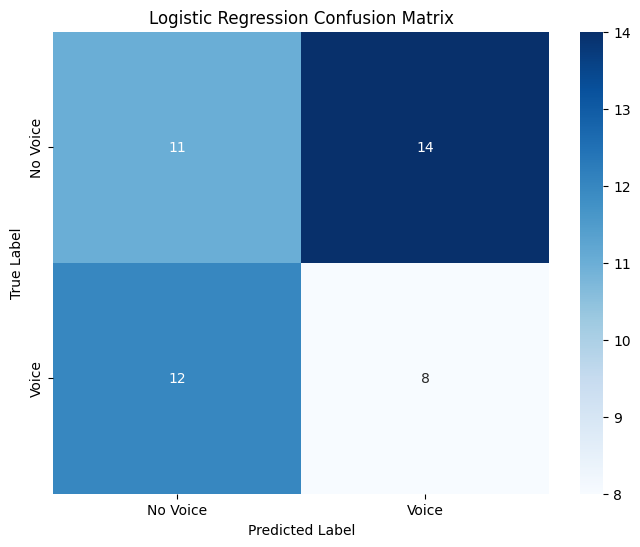

KNN Average Accuracy: 0.6666666666666666
KNN Test Accuracy: 0.5111111111111111


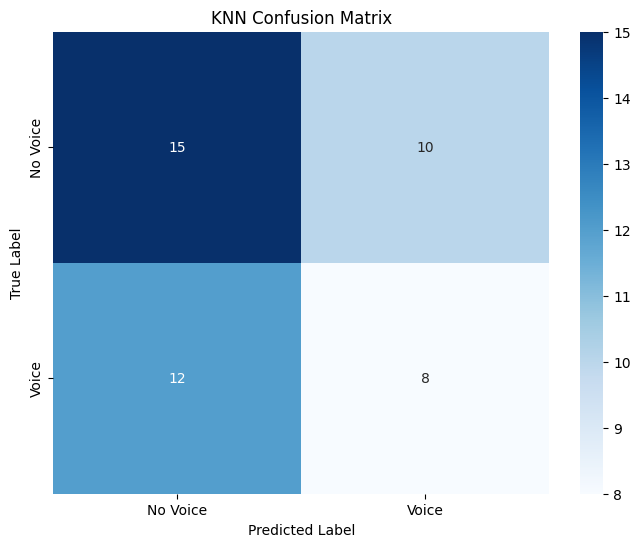

In [10]:
import os
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from pydub import AudioSegment
from scipy.io import wavfile
from python_speech_features import mfcc
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Function to extract features from an MP3 file
def extract_features(file_path, max_sequence_length=None):
    audio = AudioSegment.from_mp3(file_path)
    if audio.channels > 1:
        audio = audio.set_channels(1)
    temp_wav_path = "/tmp/temp.wav"
    audio.export(temp_wav_path, format="wav")
    rate, signal = wavfile.read(temp_wav_path)
    nfft_value = 2048
    mfcc_features = mfcc(signal, rate, nfft=nfft_value)
    mean_sequence_length = int(np.mean([len(seq) for seq in mfcc_features]))
    max_sequence_length = mean_sequence_length if max_sequence_length is None else max_sequence_length
    mfcc_features = pad_sequences([mfcc_features], maxlen=max_sequence_length, padding='post', truncating='post')[0]
    flat_features = np.ravel(mfcc_features)
    return flat_features

# Function to load or save preprocessed data
def load_or_save_preprocessed_data(directory, max_songs_per_category=10, save_path=None, load_path=None):
    if load_path is not None and os.path.isfile(load_path):
        # Load data from the specified path
        loaded_data = np.load(load_path)
        if 'features' in loaded_data:
            X, y, features = loaded_data['X'], loaded_data['y'], loaded_data['features']
            print("Data loaded from:", load_path)
        else:
            # Handle loading old data without the 'features' key
            print("Old data loaded from:", load_path)
            print("Reprocessing data...")
            X, y, features = process_and_save_data(directory, max_songs_per_category, save_path)
    else:
        # Load or save the data
        print("Processing data...")
        X, y, features = process_and_save_data(directory, max_songs_per_category, save_path)

    return X, y, features

def process_and_save_data(directory, max_songs_per_category, save_path):
    features = []
    labels = {'voice': 0, 'no_voice': 0}
    for filename in os.listdir(directory):
        if filename.endswith(".mp3"):
            file_path = os.path.join(directory, filename)
            if 'no_voice' in filename.lower() and labels['no_voice'] < max_songs_per_category:
                labels['no_voice'] += 1
                features.append(extract_features(file_path))
            elif 'voice' in filename.lower() and labels['voice'] < max_songs_per_category:
                labels['voice'] += 1
                features.append(extract_features(file_path))
    X = np.array(features)
    y = np.array([0] * labels['no_voice'] + [1] * labels['voice'])
    if save_path is not None:
        np.savez(save_path, X=X, y=y, features=features)
        print("Data saved to:", save_path)
    return X, y, features

# Load or save preprocessed data
dataset_directory = '/content/drive/MyDrive/EmilysPersonalFolder/music'
preprocessed_save_path = '/content/drive/MyDrive/EmilysPersonalFolder/music/preprocessed_data.npz'
X, y, features = load_or_save_preprocessed_data(dataset_directory, max_songs_per_category=45, save_path=preprocessed_save_path, load_path=preprocessed_save_path)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Define classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier()
}

# Iterate over classifiers
for clf_name, clf in classifiers.items():
    if clf_name == 'Logistic Regression':
        pca_pipeline = make_pipeline(StandardScaler(), PCA())
    else:
        pca_pipeline = make_pipeline(PCA())

    param_grid = {'pca__n_components': [5, 10, 15, 20]}
    grid_search = GridSearchCV(pca_pipeline, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    best_components = grid_search.best_params_['pca__n_components']

    if clf_name == 'Logistic Regression':
        final_pipeline = make_pipeline(StandardScaler(), PCA(n_components=best_components), clf)
    else:
        final_pipeline = make_pipeline(PCA(n_components=best_components), clf)

    cv_results = cross_validate(final_pipeline, X_train, y_train, cv=5, scoring='accuracy')
    average_accuracy = np.mean(cv_results['test_score'])
    print(f"{clf_name} Average Accuracy: {average_accuracy}")

    final_pipeline.fit(X_train, y_train)
    y_pred = final_pipeline.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"{clf_name} Test Accuracy: {accuracy}")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['No Voice', 'Voice'], yticklabels=['No Voice', 'Voice'])
    plt.title(f"{clf_name} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


# Neural Network

Basic Neural Network
Did a terrible job. 33% accuracy.

In [12]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load or preprocess your data (modify this based on your data loading function)
# For example, you can use the load_or_save_preprocessed_data function you've defined earlier

# Load or save preprocessed data
dataset_directory = '/content/drive/MyDrive/EmilysPersonalFolder/music'
preprocessed_save_path = '/content/drive/MyDrive/EmilysPersonalFolder/music/preprocessed_data.npz'
X, y, features = load_or_save_preprocessed_data(dataset_directory, max_songs_per_category=45, save_path=preprocessed_save_path, load_path=preprocessed_save_path)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build a simple neural network
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate on the test set
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int).flatten()
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)


Data loaded from: /content/drive/MyDrive/EmilysPersonalFolder/music/preprocessed_data.npz
Epoch 1/50
2/2 [==============================] - 2s 431ms/step - loss: 0.6898 - accuracy: 0.4386 - val_loss: 0.7964 - val_accuracy: 0.5333
Epoch 2/50
2/2 [==============================] - 0s 71ms/step - loss: 0.5195 - accuracy: 0.7368 - val_loss: 0.8218 - val_accuracy: 0.6000
Epoch 3/50
2/2 [==============================] - 0s 77ms/step - loss: 0.4449 - accuracy: 0.7719 - val_loss: 0.8634 - val_accuracy: 0.5333
Epoch 4/50
2/2 [==============================] - 0s 139ms/step - loss: 0.3958 - accuracy: 0.7895 - val_loss: 0.9016 - val_accuracy: 0.5333
Epoch 5/50
2/2 [==============================] - 0s 209ms/step - loss: 0.3475 - accuracy: 0.8596 - val_loss: 0.9381 - val_accuracy: 0.5333
Epoch 6/50
1/1 [==============================] - 0s 89ms/step
Test Accuracy: 0.3333333333333333


edited parameters and created a more complex network
improved accuracy, but still under 50%

Data loaded from: /content/drive/MyDrive/EmilysPersonalFolder/music/preprocessed_data.npz
Epoch 1/50
2/2 [==============================] - 2s 311ms/step - loss: 4.0156 - accuracy: 0.5278 - val_loss: 2.1980 - val_accuracy: 0.4444
Epoch 2/50
2/2 [==============================] - 0s 59ms/step - loss: 3.4788 - accuracy: 0.4722 - val_loss: 2.7410 - val_accuracy: 0.3333
Epoch 3/50
2/2 [==============================] - 0s 67ms/step - loss: 3.8873 - accuracy: 0.6111 - val_loss: 3.0174 - val_accuracy: 0.3333
Epoch 4/50
2/2 [==============================] - 0s 58ms/step - loss: 3.2496 - accuracy: 0.5833 - val_loss: 3.3030 - val_accuracy: 0.3333
Epoch 5/50
2/2 [==============================] - 0s 50ms/step - loss: 4.6099 - accuracy: 0.4444 - val_loss: 3.4169 - val_accuracy: 0.3333
Epoch 6/50
2/2 [==============================] - 0s 55ms/step - loss: 3.2224 - accuracy: 0.7500 - val_loss: 3.4585 - val_accuracy: 0.4444
Epoch 7/50
2/2 [==============================] - 0s 70ms/step - loss: 2.01

2/2 [==============================] - 0s 7ms/step
Test Accuracy: 0.4888888888888889


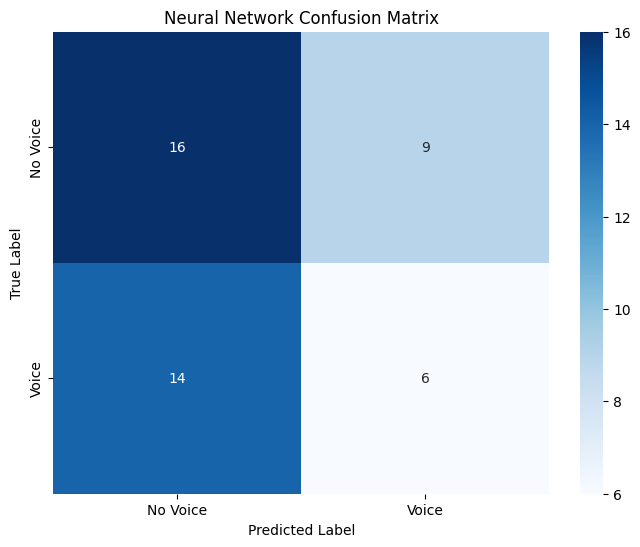

In [19]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load or save preprocessed data
dataset_directory = '/content/drive/MyDrive/EmilysPersonalFolder/music'
preprocessed_save_path = '/content/drive/MyDrive/EmilysPersonalFolder/music/preprocessed_data.npz'
X, y, features = load_or_save_preprocessed_data(dataset_directory, max_songs_per_category=45, save_path=preprocessed_save_path, load_path=preprocessed_save_path)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Build a more complex neural network
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with adjusted learning rate
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with more epochs
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)  # Threshold the probabilities
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Show confusion matrix with seaborn heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['No Voice', 'Voice'], yticklabels=['No Voice', 'Voice'])
plt.title("Neural Network Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Increased epochs, normalized inmput data, Modified Neural Network Architecture, Adjusted Learning Rate in Model Compilation, Increased Number of Epochs in Model Training

Now we are above 60%

It could be that we need more data.




Data loaded from: /content/drive/MyDrive/EmilysPersonalFolder/music/preprocessed_data.npz
Epoch 1/100
2/2 - 3s - loss: 1.1287 - accuracy: 0.5000 - val_loss: 0.7419 - val_accuracy: 0.5556 - 3s/epoch - 1s/step
Epoch 2/100
2/2 - 0s - loss: 1.0327 - accuracy: 0.4722 - val_loss: 0.7401 - val_accuracy: 0.5556 - 37ms/epoch - 19ms/step
Epoch 3/100
2/2 - 0s - loss: 1.0479 - accuracy: 0.5278 - val_loss: 0.7387 - val_accuracy: 0.4444 - 41ms/epoch - 21ms/step
Epoch 4/100
2/2 - 0s - loss: 1.2293 - accuracy: 0.4722 - val_loss: 0.7387 - val_accuracy: 0.4444 - 65ms/epoch - 32ms/step
Epoch 5/100
2/2 - 0s - loss: 0.8839 - accuracy: 0.4722 - val_loss: 0.7395 - val_accuracy: 0.4444 - 64ms/epoch - 32ms/step
Epoch 6/100
2/2 - 0s - loss: 1.0797 - accuracy: 0.3611 - val_loss: 0.7402 - val_accuracy: 0.4444 - 48ms/epoch - 24ms/step
Epoch 7/100
2/2 - 0s - loss: 0.8871 - accuracy: 0.4167 - val_loss: 0.7415 - val_accuracy: 0.4444 - 57ms/epoch - 29ms/step
Epoch 8/100
2/2 - 0s - loss: 0.8723 - accuracy: 0.5556 - val

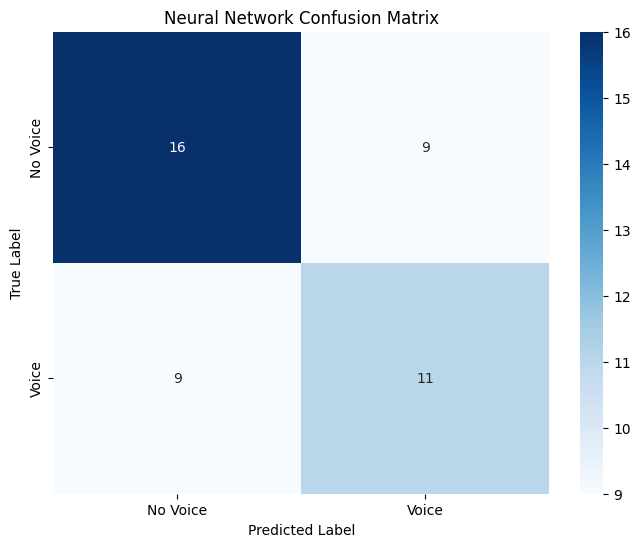

In [20]:

# Load or save preprocessed data
dataset_directory = '/content/drive/MyDrive/EmilysPersonalFolder/music'
preprocessed_save_path = '/content/drive/MyDrive/EmilysPersonalFolder/music/preprocessed_data.npz'
X, y, features = load_or_save_preprocessed_data(dataset_directory, max_songs_per_category=45, save_path=preprocessed_save_path, load_path=preprocessed_save_path)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Normalize input data
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Build a more complex neural network
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train_normalized.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with adjusted learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with more epochs
history = model.fit(X_train_normalized, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=2)

# Evaluate the model on the test set
y_pred_prob = model.predict(X_test_normalized)
y_pred = (y_pred_prob > 0.5).astype(int)  # Threshold the probabilities
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Show confusion matrix with seaborn heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['No Voice', 'Voice'], yticklabels=['No Voice', 'Voice'])
plt.title("Neural Network Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Lets systmatically change parameters then graph them to see how they change the results.

Data loaded from: /content/drive/MyDrive/EmilysPersonalFolder/music/preprocessed_data.npz
2/2 [==============================] - 0s 6ms/step


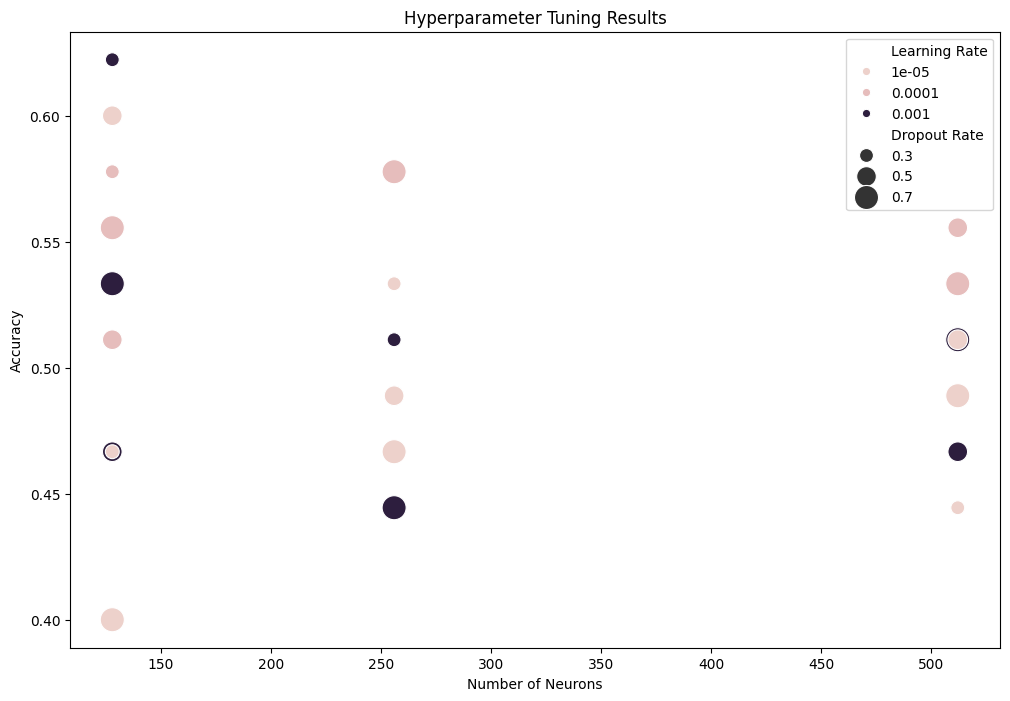

In [21]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# Load or save preprocessed data
dataset_directory = '/content/drive/MyDrive/EmilysPersonalFolder/music'
preprocessed_save_path = '/content/drive/MyDrive/EmilysPersonalFolder/music/preprocessed_data.npz'
X, y, features = load_or_save_preprocessed_data(dataset_directory, max_songs_per_category=45, save_path=preprocessed_save_path, load_path=preprocessed_save_path)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Normalize input data
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Define hyperparameters to experiment with
learning_rates = [0.001, 0.0001, 0.00001]
neurons_list = [128, 256, 512]
dropout_rates = [0.3, 0.5, 0.7]

# Initialize lists to store results
results = []

# Loop through different hyperparameters
for lr in learning_rates:
    for neurons in neurons_list:
        for dropout_rate in dropout_rates:
            # Build a neural network with current hyperparameters
            model = Sequential()
            model.add(Dense(neurons, activation='relu', input_shape=(X_train_normalized.shape[1],)))
            model.add(Dropout(dropout_rate))
            model.add(Dense(neurons // 2, activation='relu'))
            model.add(Dropout(dropout_rate))
            model.add(Dense(1, activation='sigmoid'))

            # Compile the model with current learning rate
            model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

            # Train the model
            history = model.fit(X_train_normalized, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

            # Evaluate the model on the test set
            y_pred_prob = model.predict(X_test_normalized)
            y_pred = (y_pred_prob > 0.5).astype(int)
            accuracy = accuracy_score(y_test, y_pred)

            # Store results
            results.append({
                'Learning Rate': lr,
                'Neurons': neurons,
                'Dropout Rate': dropout_rate,
                'Accuracy': accuracy
            })

# Create a DataFrame for better visualization
import pandas as pd
results_df = pd.DataFrame(results)

# Visualize results
plt.figure(figsize=(12, 8))
sns.scatterplot(data=results_df, x='Neurons', y='Accuracy', hue='Learning Rate', size='Dropout Rate', sizes=(100, 300))
plt.title('Hyperparameter Tuning Results')
plt.xlabel('Number of Neurons')
plt.ylabel('Accuracy')
plt.show()
